In [ ]:
import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import tqdm
import cv2
from glob import glob
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
from vit_jax import models

2024-11-26 09:26:38.764264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732593398.798775  101701 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732593398.808789  101701 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
[name for name in models.model_configs.MODEL_CONFIGS if name.startswith('LiT')]

['LiT-B16B', 'LiT-B16B_2', 'LiT-L16L', 'LiT-L16S', 'LiT-L16Ti']

In [3]:
model_name = 'LiT-B16B'

lit_model = models.get_model(model_name)
# Loading the variables from cloud can take a while the first time...
lit_variables = lit_model.load_variables()
# Creating tokens from freeform text (see next section).
tokenizer = lit_model.get_tokenizer()
# Resizing images & converting value range to -1..1 (see next section).
image_preprocessing = lit_model.get_image_preprocessing()
# Preprocessing op for use in tfds pipeline (see last section).
pp = lit_model.get_pp()


⚠️ Reusing local copy: LiT-B16B.npz


2024-11-26 09:26:46.021463: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2024-11-26 09:26:46.130699: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


In [4]:
print(lit_model)
type(lit_model)

LitModel(
    # attributes
    image = classifier: token
    hidden_size: 768
    model_name: ViT-B_16
    patches:
      size: !!python/tuple
      - 16
      - 16
    representation_size: null
    transformer:
      attention_dropout_rate: 0.0
      dropout_rate: 0.0
      mlp_dim: 3072
      num_heads: 12
      num_layers: 12
    
    text_model = 'bert'
    text = config: base
    
    pp = max_len: 16
    size: 224
    tokenizer_name: bert
    
    out_dim = (768, 768)
    model_name = 'LiT-B16B'
)


vit_jax.models_lit.LitModel

In [5]:
lit_model.out_dim

(768, 768)

In [6]:
from vit_jax.models_vit import VisionTransformer
image_model = VisionTransformer(
    **{
        **lit_model.image,
        'num_classes': lit_model.out_dim[0],
    }, name='img'
)
image_model

VisionTransformer(
    # attributes
    num_classes = 768
    patches = size: !!python/tuple
    - 16
    - 16
    
    transformer = attention_dropout_rate: 0.0
    dropout_rate: 0.0
    mlp_dim: 3072
    num_heads: 12
    num_layers: 12
    
    hidden_size = 768
    resnet = None
    representation_size = None
    classifier = 'token'
    head_bias_init = 0.0
    encoder = Encoder
    model_name = 'ViT-B_16'
)

In [7]:
from jax.experimental import jax2tf

tf_model = tf.function(jax2tf.convert(image_model), autograph=False)
tf_model

In [8]:
dataset = "/home/mnjm/workspace/clip/dataset/train/*/*.jpg"
imgs_l = glob(dataset)
imgs_l = [ x for x in imgs_l if "cropped" not in x ]
print(len(imgs_l))

5537


In [9]:
labels = ['raw', 'translucent', 'golden brown']
texts = [ f"{label} chopped onions in a dark pan" for label in labels ]

tokens = tokenizer(texts)
tokens.shape

(3, 16)

In [10]:
imgs_np_l = []
for img_p in imgs_l[:5]:
    img_cv = cv2.imread(img_p)
    img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    if img_cv.shape[0] == 128 and img_cv.shape[1] == 128: continue
    imgs_np_l.append(img_cv)
print(len(imgs_np_l), [ imgs_np_l[i].shape for i in range(len(imgs_np_l)) ])

5 [(2560, 1920, 3), (2560, 1920, 3), (2560, 1920, 3), (1920, 2560, 3), (2560, 1920, 3)]


In [11]:
images = image_preprocessing(imgs_np_l)

In [12]:
images.shape

(5, 224, 224, 3)

In [13]:
zimg, ztxt, out = lit_model.apply(lit_variables, images=images, tokens=tokens)

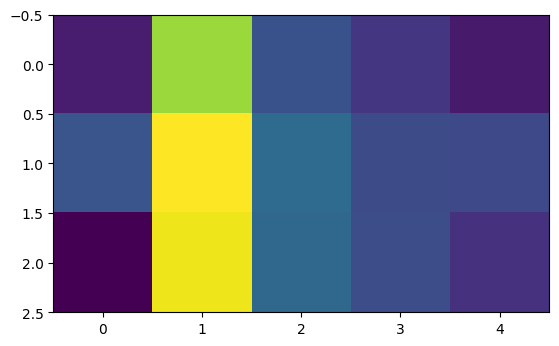

In [14]:
plt.imshow(ztxt @ zimg.T)

In [15]:
probs = np.array(jax.nn.softmax(out['t'] * ztxt @ zimg.T, axis=1))
print(probs)
pd.DataFrame(probs, index=texts).style.background_gradient('Greens', vmin=0, vmax=1).format('{:.2%}')

[[1.7339743e-04 9.9802530e-01 1.2153543e-03 4.2027727e-04 1.6562625e-04]
 [2.5978617e-04 9.9870169e-01 6.9174770e-04 1.8185773e-04 1.6486405e-04]
 [1.8232186e-05 9.9886680e-01 7.7004719e-04 2.5579840e-04 8.9182628e-05]]


,0,1,2,3,4
raw chopped onions in a dark pan,0.02%,99.80%,0.12%,0.04%,0.02%
translucent chopped onions in a dark pan,0.03%,99.87%,0.07%,0.02%,0.02%
golden brown chopped onions in a dark pan,0.00%,99.89%,0.08%,0.03%,0.01%


In [16]:
t, c = 0, 0
true_lbl_l, pred_lbl_l = [], []
import os
for img_p in tqdm(imgs_l):
    img_cv = cv2.imread(img_p)
    img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    if img_cv.shape[0] == 128 and img_cv.shape[1] == 128: continue
    images = image_preprocessing( [ img_cv ] )
    # print(images.shape, np.min(images), np.max(images))
    zimg, ztxt, out = lit_model.apply(lit_variables, images=images, tokens=tokens)
    t += 1
    probs = (ztxt @ zimg.T).reshape(-1)
    probs = np.exp(probs) / np.sum(np.exp(probs))
    assert len(probs) == len(labels)
    # print(probs)
    score = np.max(probs) * 100.0
    pred_lbl = np.argmax(probs)
    true_lbl = int(img_p.split(os.path.sep)[-2])
    true_lbl_l.append(true_lbl)
    pred_lbl_l.append(pred_lbl)
    if true_lbl != pred_lbl:
        c += 1
        # plt.title(f"{labels[pred_lbl]}({score:.2f}) (True: {labels[true_lbl]})")
        # plt.imshow(img_cv)
        # plt.show()

  0%|          | 0/5537 [00:00<?, ?it/s]

In [17]:
print(f"{c}/{t}")
assert len(true_lbl_l) == len(pred_lbl_l)
confusion_matrix(true_lbl_l, pred_lbl_l)

2903/5536


array([[  78, 1314,    0],
       [ 177, 2119,   27],
       [  50, 1335,  436]])